In [164]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import tikzplotlib
from collections import defaultdict
from tqdm import tqdm
import scipy.stats as stats
import statsmodels.stats.proportion
import re

In [2]:
mentions_df = pd.read_csv('data/mentions/mentions.word_filtered.sense_filtered.soc_mapped.merged.sentiment_added.csv', index_col=None, dtype={'soc_code':str, 'soc_name':str})
imdb_df = pd.read_csv('data/imdb/imdb.ngram.box_office.csv', index_col=None)
professions_df = pd.read_csv('data/mentions/professions.word_filtered.sense_filtered.merged.csv', index_col=None)

In [4]:
Counter(mentions_df.sentiment_label)

Counter({0: 3185808, -1: 134775, 1: 337244})

In [6]:
professions_df.head()

,profession,n_mentions,n_words,n_senses,n_noun_senses,n_professional_senses,n_non_professional_senses,profession_merge
0,doctor,213458,1,7,4,3,4,doctor
1,police,208301,1,2,1,1,1,police
2,doctor,140122,1,2,2,2,0,doctor
3,captain,117268,1,8,7,6,2,captain
4,cop,102874,1,3,1,1,2,cop


In [9]:
professions = sorted(professions_df.profession_merge.unique()[:500])

In [11]:
mentions_df = mentions_df.merge(imdb_df, left_on='imdb', right_on='imdb_ID', how='left')

In [12]:
gdf = mentions_df[mentions_df.profession_merge.isin(professions)].groupby(['profession_merge','year','sentiment_label']).agg({'imdb':len}).imdb

In [17]:
gdf = gdf.reindex(index=pd.MultiIndex.from_product([professions, np.arange(1950, 2018), [-1,0,1]], names=['profession','year','sentiment']), fill_value=0)

In [26]:
gdf = (gdf/gdf.sum(level=('profession','year'))).fillna(0)

In [27]:
gdf

profession  year  sentiment
accountant  1950  -1           0.000000
                   0           0.931034
                   1           0.068966
            1951  -1           0.000000
                   0           0.666667
                                 ...   
writer      2016   0           0.731070
                   1           0.225413
            2017  -1           0.050435
                   0           0.711304
                   1           0.238261
Name: imdb, Length: 102000, dtype: float64

In [28]:
gdf.isna().sum()

0

In [34]:
gdf.loc['accountant',:,-1].values

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02941176, 0.03125   , 0.        , 0.        ,
       0.02380952, 0.1       , 0.        , 0.06666667, 0.04347826,
       0.14705882, 0.        , 0.01694915, 0.        , 0.03448276,
       0.05      , 0.06060606, 0.0625    , 0.05263158, 0.04878049,
       0.02222222, 0.        , 0.        , 0.11627907, 0.05405405,
       0.12      , 0.        , 0.02702703, 0.        , 0.03030303,
       0.05454545, 0.075     , 0.02325581, 0.07407407, 0.06944444,
       0.05357143, 0.01639344, 0.03846154, 0.03921569, 0.07936508,
       0.04411765, 0.05882353, 0.10169492, 0.13157895, 0.08247423,
       0.11458333, 0.07142857, 0.0703125 , 0.11290323, 0.05769231,
       0.06818182, 0.07179487, 0.06451613, 0.05235602, 0.06334842,
       0.06849315, 0.07453416, 0.05940594, 0.07508532, 0.07352941,
       0.06153846, 0.04812834, 0.02439024])

In [35]:
mentions_df.soc_code.notna().sum()

3132986

In [37]:
hdf = mentions_df.groupby(['soc_code','soc_name','year','sentiment_label']).agg({'imdb':len}).imdb

In [38]:
hdf.index

MultiIndex([('11',                    'Management', 1950, -1),
            ('11',                    'Management', 1950,  0),
            ('11',                    'Management', 1950,  1),
            ('11',                    'Management', 1951, -1),
            ('11',                    'Management', 1951,  0),
            ('11',                    'Management', 1951,  1),
            ('11',                    'Management', 1952, -1),
            ('11',                    'Management', 1952,  0),
            ('11',                    'Management', 1952,  1),
            ('11',                    'Management', 1953, -1),
            ...
            ('55', 'Military Specific Occupations', 2014,  1),
            ('55', 'Military Specific Occupations', 2015, -1),
            ('55', 'Military Specific Occupations', 2015,  0),
            ('55', 'Military Specific Occupations', 2015,  1),
            ('55', 'Military Specific Occupations', 2016, -1),
            ('55', 'Military Specific O

In [39]:
mentions_df.soc_code.dropna().unique()

array(['13', '27', '11', '11;55', '41', '55', '29', '19', '17', '33',
       '51', '23', '53', '39', '35', '21', '47', '43', '45', '41;13',
       '51;47', '37', '41;43', '43;13', '11;13', '25;27', '25', '11;23',
       '49', '49;47', '37;47', '15', '41;51', '33;55', '31', '13;53',
       '11;21', '53;55', '43;11', '43;23', '11;43'], dtype=object)

In [52]:
code_year_sentiment_dict = defaultdict(lambda: {'imdb':0})

df = mentions_df[mentions_df.soc_code.notna()]
code_col = df.soc_code.values
name_col = df.soc_name.values
year_col = df.year.values
label_col = df.sentiment_label.values

for code_str, name_str, year, label in tqdm(zip(code_col, name_col, year_col, label_col), total=len(code_col)):
    for code, name in zip(code_str.split(';'), name_str.split(';')):
        code_year_sentiment_dict[(code,name,year,label)]['imdb'] += 1

100%|██████████| 3132986/3132986 [00:09<00:00, 336201.93it/s]


In [55]:
hdf = pd.DataFrame.from_dict(code_year_sentiment_dict, orient='index')

In [56]:
hdf = hdf.reindex(index=pd.MultiIndex.from_product([]))

imdb
11 Management                    1950 -1     19
                                       0    782
                                       1     64
                                 1951 -1     14
                                       0    811
...                                         ...
55 Military Specific Occupations 2016  0  11938
                                       1   1034
                                 2017 -1    179
                                       0   6049
                                       1    609

[4558 rows x 1 columns]

In [58]:
pd.MultiIndex.from_product([[(1, 'one'), (2, 'two')], ['xx','yy'], [1998, 1999]], names=['A','B','C'])

MultiIndex([((1, 'one'), 'xx', 1998),
            ((1, 'one'), 'xx', 1999),
            ((1, 'one'), 'yy', 1998),
            ((1, 'one'), 'yy', 1999),
            ((2, 'two'), 'xx', 1998),
            ((2, 'two'), 'xx', 1999),
            ((2, 'two'), 'yy', 1998),
            ((2, 'two'), 'yy', 1999)],
           names=['A', 'B', 'C'])

In [63]:
soc_sentiment_df = pd.read_csv('data/analysis_data/soc_sentiment.csv', index_col=(0,1,2))
profession_sentiment_df = pd.read_csv('data/analysis_data/top500_merged_profession_sentiment.csv', index_col=(0,1,2))

In [62]:
soc_sentiment_df

imdb
soc                                year sentiment          
Architecture and Engineering       1950 -1         0.030303
                                         0         0.757576
                                         1         0.212121
                                   1951 -1         0.045455
                                         0         0.818182
...                                                     ...
Transportation and Material Moving 2016  0         0.861544
                                         1         0.098674
                                   2017 -1         0.038087
                                         0         0.868911
                                         1         0.093003

[4692 rows x 1 columns]

In [66]:
index = soc_sentiment_df.index

In [69]:
names = index.get_level_values(level='soc').unique()

In [72]:
soc_sentiment_df.loc[names[0],:,1].values.flatten()

array([0.21212121, 0.13636364, 0.18867925, 0.09677419, 0.1875    ,
       0.16666667, 0.10309278, 0.14728682, 0.10714286, 0.10526316,
       0.09322034, 0.08139535, 0.15151515, 0.18902439, 0.14754098,
       0.15789474, 0.1459854 , 0.1352657 , 0.108     , 0.27363184,
       0.15217391, 0.14673913, 0.2       , 0.19512195, 0.2       ,
       0.10687023, 0.14110429, 0.184     , 0.19230769, 0.15151515,
       0.19354839, 0.15789474, 0.203125  , 0.13777778, 0.2247191 ,
       0.15853659, 0.13953488, 0.27230047, 0.16037736, 0.125     ,
       0.19786096, 0.1328125 , 0.1409396 , 0.18120805, 0.14572864,
       0.22222222, 0.21465969, 0.14404432, 0.14385965, 0.17784257,
       0.15270936, 0.17929293, 0.16363636, 0.20240481, 0.20392157,
       0.20127796, 0.20028011, 0.15422886, 0.17241379, 0.16721311,
       0.19555935, 0.24567789, 0.20289855, 0.19615032, 0.20863896,
       0.1969697 , 0.16080402, 0.19772257])

In [74]:
years = np.arange(1950, 2018)

In [77]:
for name in names:
    pos = soc_sentiment_df.loc[name,:,1].values.flatten()
    neg = soc_sentiment_df.loc[name,:,-1].values.flatten()
    
    pos_corr, pos_pval = stats.spearmanr(pos, years)
    neg_corr, neg_pval = stats.spearmanr(neg, years)
    
    pos_sig = 'sig' if pos_pval < 0.05 else ''
    neg_sig = 'sig' if neg_pval < 0.05 else ''
    
    print(name)
    print(f'\tpos: corr = {pos_corr:5.2f}, pval = {pos_pval:5.2e} {pos_sig}')
    print(f'\tneg: corr = {neg_corr:5.2f}, pval = {neg_pval:5.2e} {neg_sig}')
    print()

Architecture and Engineering
	pos: corr =  0.42, pval = 3.38e-04 sig
	neg: corr =  0.30, pval = 1.36e-02 sig

Arts, Design, Entertainment, Sports, and Media
	pos: corr = -0.09, pval = 4.45e-01 
	neg: corr =  0.28, pval = 2.18e-02 sig

Building and Grounds Cleaning and Maintenance
	pos: corr = -0.09, pval = 4.86e-01 
	neg: corr =  0.21, pval = 8.96e-02 

Business and Financial Operations
	pos: corr = -0.34, pval = 4.50e-03 sig
	neg: corr =  0.09, pval = 4.85e-01 

Community and Social Service
	pos: corr = -0.56, pval = 6.44e-07 sig
	neg: corr = -0.05, pval = 6.68e-01 

Computer and Mathematical
	pos: corr = -0.32, pval = 8.16e-03 sig
	neg: corr =  0.46, pval = 7.07e-05 sig

Construction and Extraction
	pos: corr = -0.15, pval = 2.20e-01 
	neg: corr =  0.16, pval = 1.80e-01 

Educational Instruction and Library
	pos: corr =  0.57, pval = 3.42e-07 sig
	neg: corr =  0.77, pval = 1.33e-14 sig

Farming, Fishing, and Forestry
	pos: corr = -0.10, pval = 4.09e-01 
	neg: corr = -0.23, pval = 5.7

In [78]:
soc_sentiment_df

imdb
soc                                year sentiment          
Architecture and Engineering       1950 -1         0.030303
                                         0         0.757576
                                         1         0.212121
                                   1951 -1         0.045455
                                         0         0.818182
...                                                     ...
Transportation and Material Moving 2016  0         0.861544
                                         1         0.098674
                                   2017 -1         0.038087
                                         0         0.868911
                                         1         0.093003

[4692 rows x 1 columns]

In [93]:
soc_sentiment_only_df = soc_sentiment_df.loc[(slice(None),slice(None),[-1,1]),:]

In [96]:
soc_sentiment_only_df.sum(level=('soc','year'))

imdb
soc                                year          
Architecture and Engineering       1950  0.242424
                                   1951  0.181818
                                   1952  0.245283
                                   1953  0.096774
                                   1954  0.229167
...                                           ...
Transportation and Material Moving 2013  0.143715
                                   2014  0.147481
                                   2015  0.153561
                                   2016  0.138456
                                   2017  0.131089

[1564 rows x 1 columns]

In [97]:
soc_sentiment_only_df = (soc_sentiment_only_df/soc_sentiment_only_df.sum(level=('soc','year'))).fillna(0)

In [98]:
soc_sentiment_only_df

imdb
soc                                year sentiment          
Architecture and Engineering       1950 -1         0.125000
                                         1         0.875000
                                   1951 -1         0.250000
                                         1         0.750000
                                   1952 -1         0.230769
...                                                     ...
Transportation and Material Moving 2015  1         0.758713
                                   2016 -1         0.287324
                                         1         0.712676
                                   2017 -1         0.290541
                                         1         0.709459

[3128 rows x 1 columns]

In [102]:
soc_sentiment_df.loc[('Architecture and Engineering',slice(None),1)].values.flatten()

array([0.21212121, 0.13636364, 0.18867925, 0.09677419, 0.1875    ,
       0.16666667, 0.10309278, 0.14728682, 0.10714286, 0.10526316,
       0.09322034, 0.08139535, 0.15151515, 0.18902439, 0.14754098,
       0.15789474, 0.1459854 , 0.1352657 , 0.108     , 0.27363184,
       0.15217391, 0.14673913, 0.2       , 0.19512195, 0.2       ,
       0.10687023, 0.14110429, 0.184     , 0.19230769, 0.15151515,
       0.19354839, 0.15789474, 0.203125  , 0.13777778, 0.2247191 ,
       0.15853659, 0.13953488, 0.27230047, 0.16037736, 0.125     ,
       0.19786096, 0.1328125 , 0.1409396 , 0.18120805, 0.14572864,
       0.22222222, 0.21465969, 0.14404432, 0.14385965, 0.17784257,
       0.15270936, 0.17929293, 0.16363636, 0.20240481, 0.20392157,
       0.20127796, 0.20028011, 0.15422886, 0.17241379, 0.16721311,
       0.19555935, 0.24567789, 0.20289855, 0.19615032, 0.20863896,
       0.1969697 , 0.16080402, 0.19772257])

In [103]:
for name in names:
    sent = soc_sentiment_only_df.loc[(name, slice(None),1)].values.flatten()
    corr, pval = stats.spearmanr(sent, np.arange(1950, 2018))
    sig = 'sig' if pval < 0.05 else ''
    print(f'{name:50s}\tcorr = {corr:5.2f}, pval = {pval:5.2e}, {sig}')

Architecture and Engineering                      	corr = -0.15, pval = 2.18e-01, 
Arts, Design, Entertainment, Sports, and Media    	corr = -0.30, pval = 1.38e-02, sig
Building and Grounds Cleaning and Maintenance     	corr = -0.22, pval = 6.60e-02, 
Business and Financial Operations                 	corr = -0.43, pval = 2.28e-04, sig
Community and Social Service                      	corr = -0.22, pval = 7.48e-02, 
Computer and Mathematical                         	corr = -0.22, pval = 7.27e-02, 
Construction and Extraction                       	corr = -0.28, pval = 2.08e-02, sig
Educational Instruction and Library               	corr = -0.49, pval = 2.49e-05, sig
Farming, Fishing, and Forestry                    	corr =  0.20, pval = 1.10e-01, 
Food Preparation and Serving Related Occupations  	corr =  0.05, pval = 6.81e-01, 
Healthcare Practitioners and Technical Occupations	corr = -0.82, pval = 7.61e-18, sig
Healthcare Support                                	corr =  0.26, pval = 

In [112]:
soc_sentiment_only_df.loc[(slice(None), 2015, 1),:]

,,,imdb
soc,year,sentiment,
Architecture and Engineering,2015,1,0.860627
"Arts, Design, Entertainment, Sports, and Media",2015,1,0.810921
Building and Grounds Cleaning and Maintenance,2015,1,0.576923
Business and Financial Operations,2015,1,0.693227
Community and Social Service,2015,1,0.559126
Computer and Mathematical,2015,1,0.684932
Construction and Extraction,2015,1,0.632000
Educational Instruction and Library,2015,1,0.720930
"Farming, Fishing, and Forestry",2015,1,0.624352


In [108]:
type(soc_sentiment_only_df)

pandas.core.frame.DataFrame

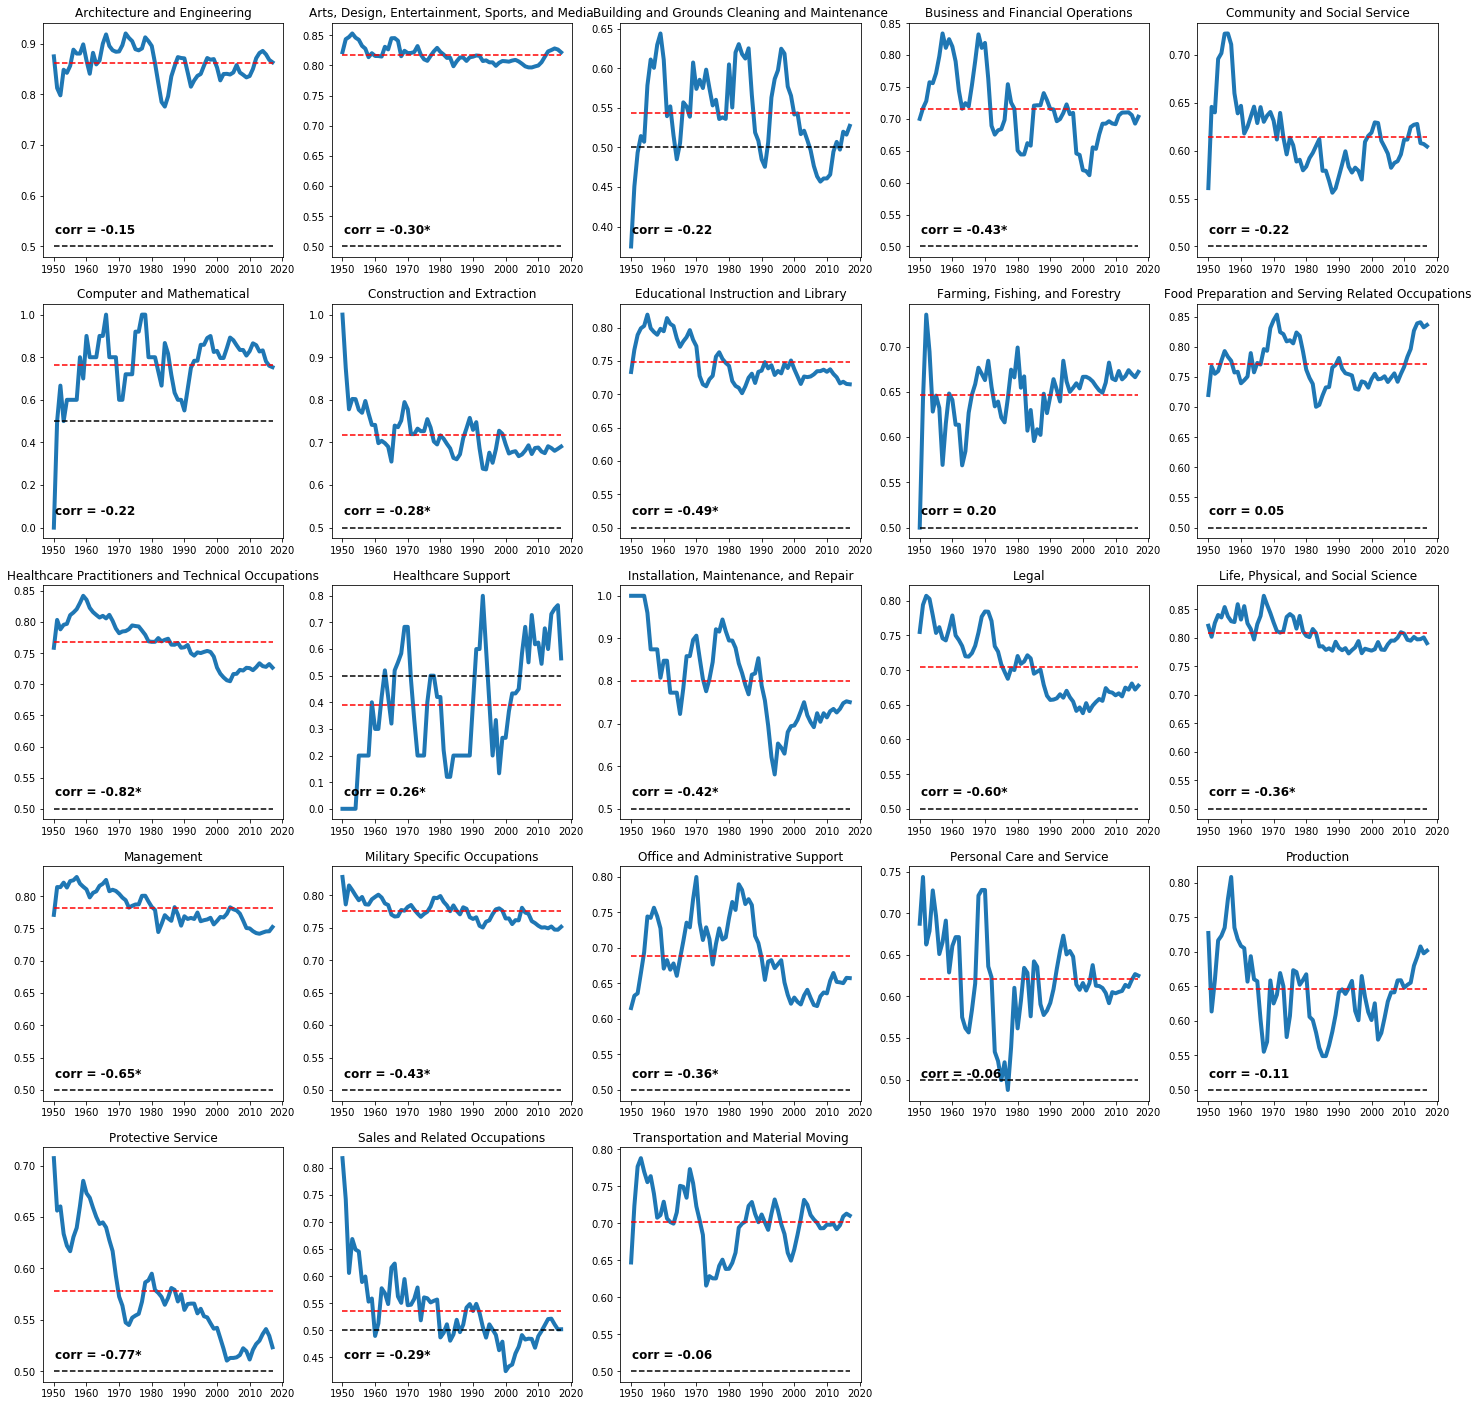

In [131]:
plt.figure(figsize=(25,25))

for i, name in enumerate(names):
    sentiment = soc_sentiment_only_df.loc[(name, slice(None), 1),:].rolling(window=5, min_periods=1).mean().values.flatten()
    raw_sentiment = soc_sentiment_only_df.loc[(name, slice(None), 1),:].values.flatten()
    corr, pval = stats.spearmanr(raw_sentiment, years)
    sig = '*' if pval < 0.05 else ''
    ax = plt.subplot(5,5,i+1)
    ax.plot(years, sentiment, lw=4)
    ax.plot(years, np.full(len(years), fill_value=0.5), ls='--', color='black')
    ax.plot(years, np.full(len(years), fill_value=np.mean(sentiment)), ls='--', color='red')
    ax.set_title(name)
    ax.annotate(f'corr = {corr:.2f}{sig}', (0.05,0.1), xycoords='axes fraction', fontweight='bold', fontsize='large')
    
plt.show()

In [132]:
soc_sentiment_df = pd.read_csv('data/analysis_data/soc_sentiment.csv', index_col=[0,1,2])
profession_sentiment_df = pd.read_csv('data/analysis_data/top500_merged_profession_sentiment.csv', index_col=[0,1,2])

In [133]:
soc_sentiment_df

imdb
soc                                year sentiment      
Architecture and Engineering       1950 -1            1
                                         0           25
                                         1            7
                                   1951 -1            3
                                         0           54
...                                                 ...
Transportation and Material Moving 2016  0         2209
                                         1          253
                                   2017 -1           43
                                         0          981
                                         1          105

[4692 rows x 1 columns]

In [134]:
soc_sentiment_df.loc[('Architecture and Engineering',slice(None),1),:]

imdb
soc                          year sentiment      
Architecture and Engineering 1950 1             7
                             1951 1             9
                             1952 1            10
                             1953 1             6
                             1954 1             9
...                                           ...
                             2013 1           214
                             2014 1           256
                             2015 1           247
                             2016 1           224
                             2017 1           191

[68 rows x 1 columns]

In [194]:
names = soc_sentiment_df.index.get_level_values('soc').unique()

In [195]:
names

Index(['Architecture and Engineering',
       'Arts, Design, Entertainment, Sports, and Media',
       'Building and Grounds Cleaning and Maintenance',
       'Business and Financial Operations', 'Community and Social Service',
       'Computer and Mathematical', 'Construction and Extraction',
       'Educational Instruction and Library', 'Farming, Fishing, and Forestry',
       'Food Preparation and Serving Related Occupations',
       'Healthcare Practitioners and Technical Occupations',
       'Healthcare Support', 'Installation, Maintenance, and Repair', 'Legal',
       'Life, Physical, and Social Science', 'Management',
       'Military Specific Occupations', 'Office and Administrative Support',
       'Personal Care and Service', 'Production', 'Protective Service',
       'Sales and Related Occupations', 'Transportation and Material Moving'],
      dtype='object', name='soc')

In [146]:
p_array = []
corr_array = []

for name in names:
    pos = soc_sentiment_df.loc[(name, slice(None), 1),:].values.flatten()
    neg = soc_sentiment_df.loc[(name, slice(None), -1),:].values.flatten()
    
    N = (pos + neg).sum()
    n = pos.sum()
    zstat, pval = statsmodels.stats.proportion.proportions_ztest(n, N, value=0.5, alternative='larger')
    sig = 'sig' if pval < 0.05 else ''
    print(f'{name:50s}\n\tp = {n/N:5.2f} {sig}')
    p_array.append(n/N)
    
    trend = pos/(pos + neg + 1e-23)
    trend = np.nan_to_num(trend, nan=0)
    corr, pval = stats.spearmanr(trend, np.arange(len(trend)))
    sig = 'sig' if pval < 0.05 else ''
    print(f'\tcorr = {corr:5.2f} {sig}')
    corr_array.append(corr)
    
    print()

Architecture and Engineering                      
	p =  0.86 sig
	corr = -0.15 

Arts, Design, Entertainment, Sports, and Media    
	p =  0.81 sig
	corr = -0.30 sig

Building and Grounds Cleaning and Maintenance     
	p =  0.52 sig
	corr = -0.22 

Business and Financial Operations                 
	p =  0.70 sig
	corr = -0.43 sig

Community and Social Service                      
	p =  0.61 sig
	corr = -0.22 

Computer and Mathematical                         
	p =  0.82 sig
	corr = -0.22 

Construction and Extraction                       
	p =  0.69 sig
	corr = -0.28 sig

Educational Instruction and Library               
	p =  0.73 sig
	corr = -0.49 sig

Farming, Fishing, and Forestry                    
	p =  0.66 sig
	corr =  0.20 

Food Preparation and Serving Related Occupations  
	p =  0.81 sig
	corr =  0.05 

Healthcare Practitioners and Technical Occupations
	p =  0.74 sig
	corr = -0.82 sig

Healthcare Support                                
	p =  0.69 sig
	corr =  0.26 sig

6207

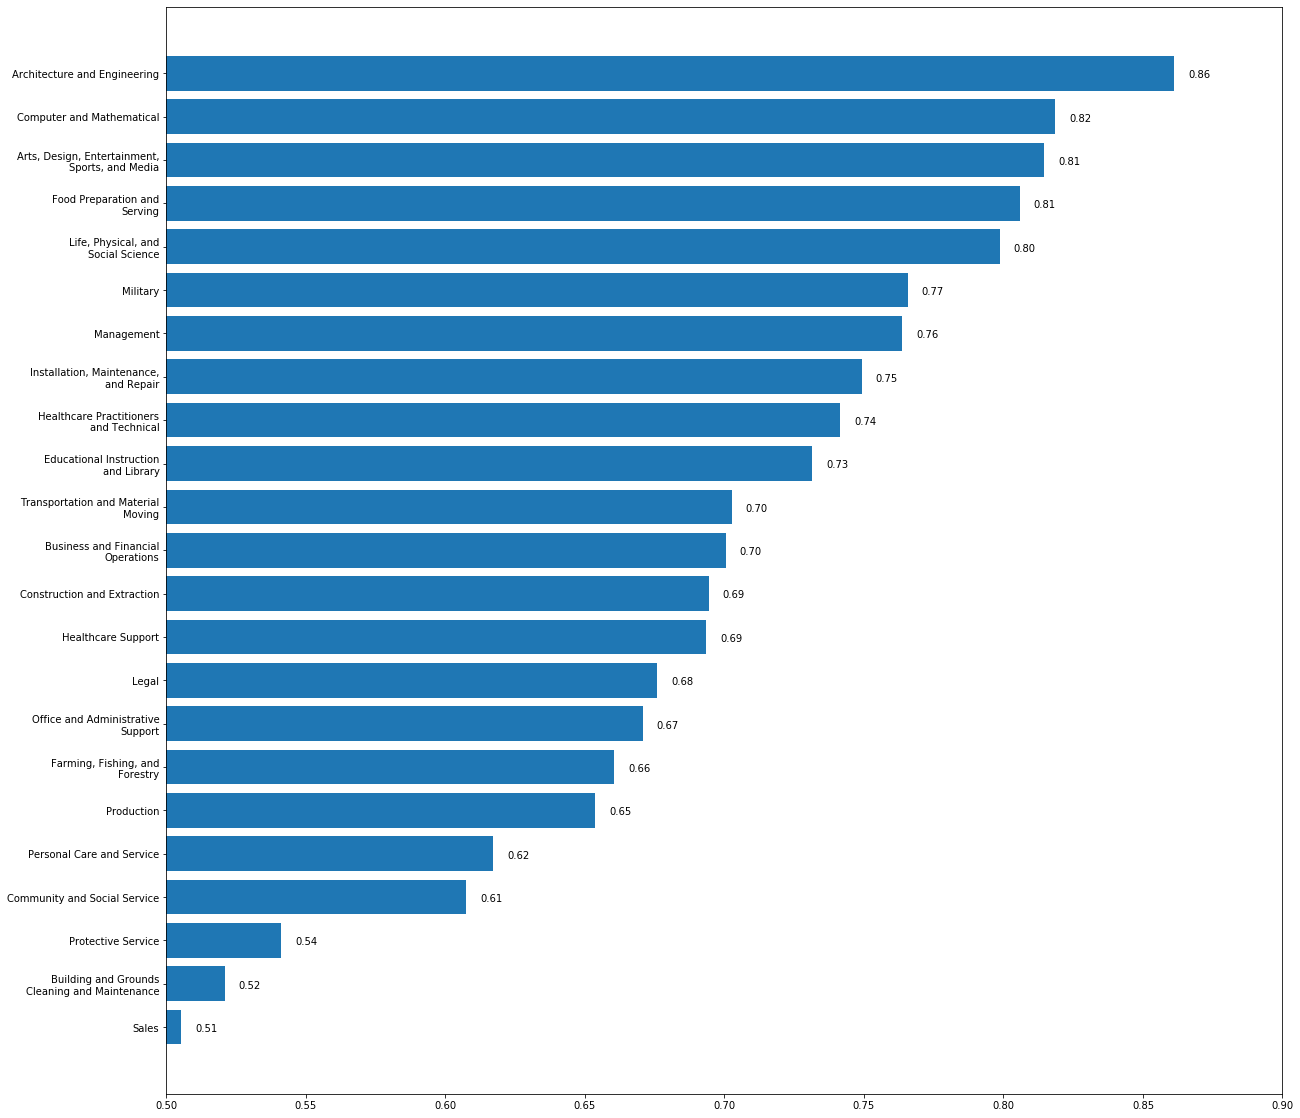

In [201]:
hnames = np.array(names)
hnames3 = np.array(names3)
hp_array = np.array(p_array)
idx = np.argsort(hp_array)
hnames = hnames[idx]
hnames3 = hnames3[idx]
hp_array = hp_array[idx]

plt.figure(figsize=(20, 20))
plt.barh(np.arange(23), hp_array)
plt.yticks(ticks=np.arange(23), labels=hnames3)
plt.xlim(0.5, 0.9)

for i, p in enumerate(hp_array):
    plt.text(p + 0.005, i-0.1, f"{p:.2f}")
    
tikzplotlib.save('data/analysis_data/soc_sentiment_avg.tex')

content = open('data/analysis_data/soc_sentiment_avg.tex').read()
content = content.replace('\\begin{tikzpicture}','\\pgfplotsset{width=16cm,height=16cm}\n\\begin{tikzpicture}')

for name, p in zip(hnames3, hp_array):
    content = content.replace(f'{{{p:.2f}}};', f'{{\\large{{\\textbf{{{p:.2f}}}}}}};')
    content = content.replace(f'{{{name}}};', f'{{\\large{{\\textbf{{{name}}}}}}};')
    
open('data/analysis_data/soc_sentiment_avg.tex','w').write(content)

In [196]:
names

Index(['Architecture and Engineering',
       'Arts, Design, Entertainment, Sports, and Media',
       'Building and Grounds Cleaning and Maintenance',
       'Business and Financial Operations', 'Community and Social Service',
       'Computer and Mathematical', 'Construction and Extraction',
       'Educational Instruction and Library', 'Farming, Fishing, and Forestry',
       'Food Preparation and Serving Related Occupations',
       'Healthcare Practitioners and Technical Occupations',
       'Healthcare Support', 'Installation, Maintenance, and Repair', 'Legal',
       'Life, Physical, and Social Science', 'Management',
       'Military Specific Occupations', 'Office and Administrative Support',
       'Personal Care and Service', 'Production', 'Protective Service',
       'Sales and Related Occupations', 'Transportation and Material Moving'],
      dtype='object', name='soc')

In [197]:
names2 = ['Architecture and Engineering','Arts, Design, Entertainment, Sports, and Media','Building and Grounds Cleaning and Maintenance','Business and Financial Operations','Community and Social Service','Computer and Mathematical','Construction and Extraction','Educational Instruction and Library','Farming, Fishing, and Forestry','Food Preparation and Serving','Healthcare Practitioners and Technical','Healthcare Support','Installation, Maintenance, and Repair','Legal','Life, Physical, and Social Science','Management','Military','Office and Administrative Support','Personal Care and Service','Production','Protective Service','Sales','Transportation and Material Moving']

In [198]:
names3 = [
    'Architecture and Engineering',
    'Arts, Design, Entertainment,\nSports, and Media',
    'Building and Grounds\nCleaning and Maintenance',
    'Business and Financial\nOperations',
    'Community and Social Service',
    'Computer and Mathematical',
    'Construction and Extraction',
    'Educational Instruction\nand Library',
    'Farming, Fishing, and\nForestry',
    'Food Preparation and\nServing',
    'Healthcare Practitioners\nand Technical',
    'Healthcare Support',
    'Installation, Maintenance,\nand Repair',
    'Legal',
    'Life, Physical, and\nSocial Science',
    'Management',
    'Military',
    'Office and Administrative\nSupport',
    'Personal Care and Service',
    'Production',
    'Protective Service',
    'Sales',
    'Transportation and Material\nMoving'
]

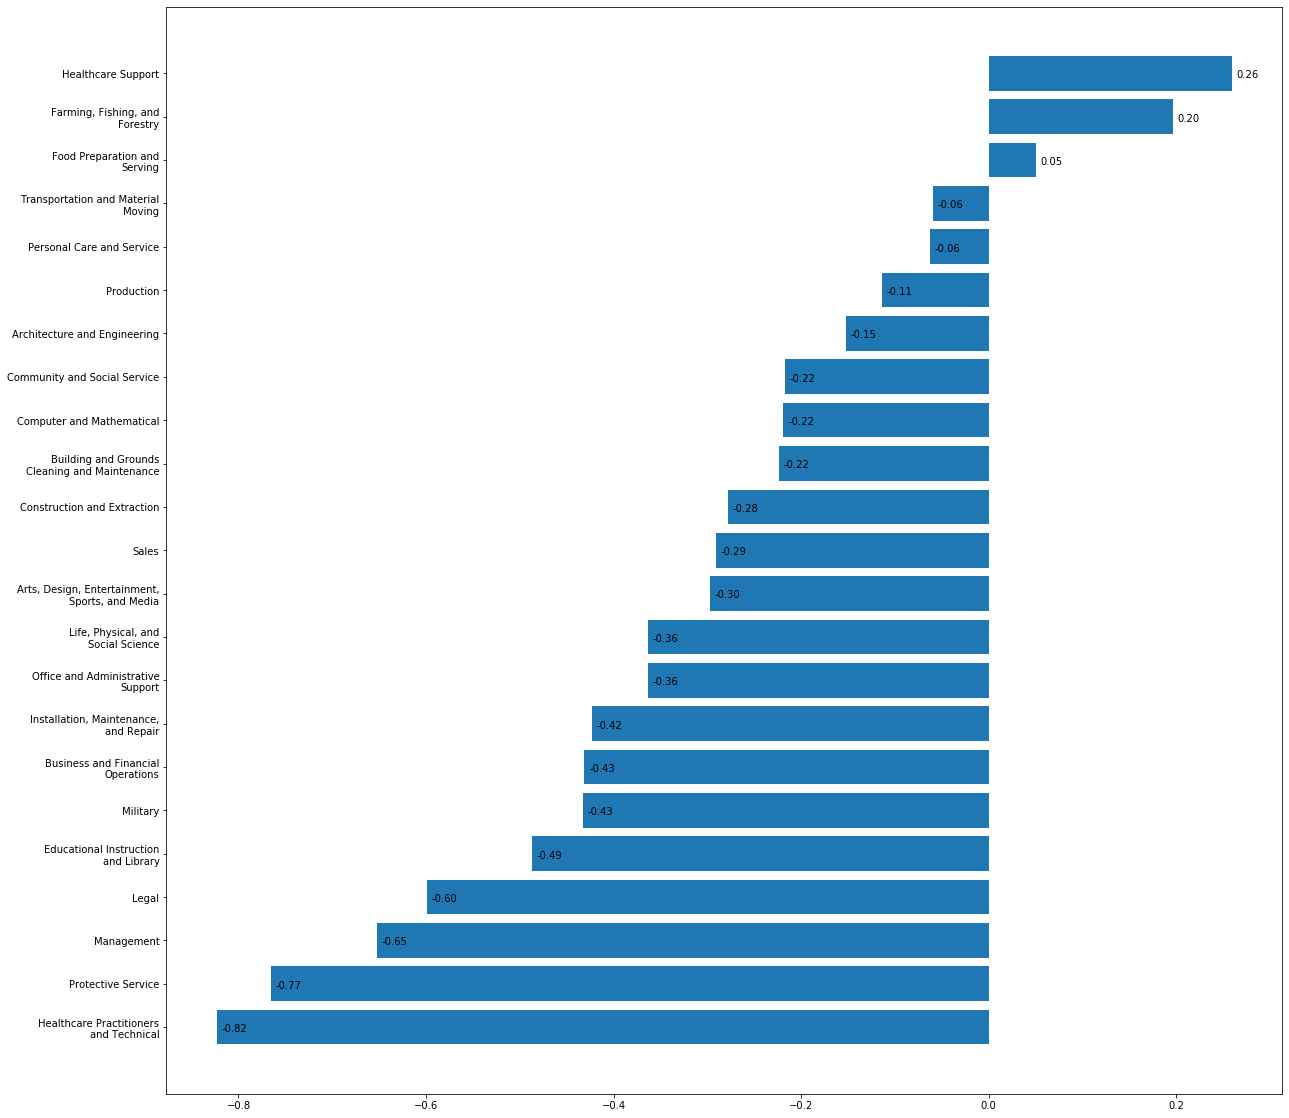

In [202]:
hnames3 = np.array(names3)
hcorr_array = np.array(corr_array)
idx = np.argsort(hcorr_array)
hnames3 = hnames3[idx]
hcorr_array = hcorr_array[idx]

plt.figure(figsize=(20, 20))
plt.barh(np.arange(23), hcorr_array)
plt.yticks(ticks=np.arange(23), labels=hnames3)
# plt.xlim(0.5, 0.9)

for i, p in enumerate(hcorr_array):
    plt.text(p + 0.005, i-0.1, f"{p:.2f}")
    
tikzplotlib.save('data/analysis_data/soc_sentiment_trend.tex')

# content = open('data/analysis_data/soc_sentiment_trend.tex').read()
# content = content.replace('\\begin{tikzpicture}','\\pgfplotsset{width=16cm,height=16cm}\n\\begin{tikzpicture}')

# for name, p in zip(hnames3, hp_array):
#     content = content.replace(f'{{{p:.2f}}};', f'{{\\large{{\\textbf{{{p:.2f}}}}}}};')
#     content = content.replace(f'{{{name}}};', f'{{\\large{{\\textbf{{{name}}}}}}};')
    
# open('data/analysis_data/soc_sentiment_avg.tex','w').write(content)

In [203]:
profession_sentiment_df

imdb
profession    year sentiment      
doctor        1950 -1           31
                    0         1398
                    1          112
              1951 -1           19
                    0         1209
...                            ...
sketch artist 2016  0           35
                    1            2
              2017 -1            0
                    0           13
                    1            3

[102000 rows x 1 columns]

In [205]:
professions = sorted(profession_sentiment_df.index.get_level_values(level='profession').unique())

In [217]:
records = []

for profession in professions:
    pos = profession_sentiment_df.loc[(profession, slice(None), 1)].values.flatten()
    neg = profession_sentiment_df.loc[(profession, slice(None), -1)].values.flatten()
    n = pos.sum()
    N = pos.sum() + neg.sum()
    trend = pos/(pos + neg + 1e-23)
    p = n/(N)
    
    corr, pval = stats.spearmanr(np.arange(68), trend)
    zstat, pval2 = statsmodels.stats.proportion.proportions_ztest(n, N, value=0.5, alternative='larger')
    
    records.append([profession, corr, pval, p, pval2])
    
profession_sentiment_trend_df = pd.DataFrame(records, columns=['profession','correlation','correlation_pvalue','proportion','proportion_pvalue'])

/home/sbaruah/.pyenv/versions/3.6.7/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/sbaruah/.pyenv/versions/3.6.7/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/sbaruah/.pyenv/versions/3.6.7/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/sbaruah/.pyenv/versions/3.6.7/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/sbaruah/.pyenv/versions/3.6.7/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/sbaruah/.pyenv/versions/3.6.7/lib/python3.6/site-packages/statsmodels/stats/weig

In [223]:
df = profession_sentiment_trend_df.copy()
df = df.dropna()
df = df[df.proportion_pvalue < 0.05]
professions_sorted_by_proportion = df.sort_values(by='proportion').profession

print('top 10 professions with highest proportion')
print(professions_sorted_by_proportion[-10:])
print()

print('top 10 professions with lowest proportion')
print(professions_sorted_by_proportion[:10])
print()

top 10 professions with highest proportion
180              film star
1                  acrobat
128              craftsman
487               vocalist
394               retailer
451             supermodel
368    production designer
88         cinematographer
276             masterchef
258              lifesaver
Name: profession, dtype: object

top 10 professions with lowest proportion
144     dentist
264        maid
93        clerk
353    preacher
300       nanny
158     doorman
140        dean
63       butler
127      cowboy
59       broker
Name: profession, dtype: object



In [227]:
df.proportion.min()

0.5319148936170213

In [232]:
profession_sentiment_df.loc[(slice(None),slice(None),[-1,1]),:].sum(level=('profession','sentiment'))

imdb
profession      sentiment       
doctor          -1          8987
                 1         30139
police          -1          7179
                 1          4435
captain         -1          1971
...                          ...
cinematographer  1            63
chief executive -1            13
                 1            36
sketch artist   -1             7
                 1            24

[1000 rows x 1 columns]